In [9]:
import torch.optim as optim
from torch.utils.data import DataLoader

# For visualization
import matplotlib.pyplot as plt

# For Numerical computations
import numpy as np

# This is need when you want to execute the package from another folder
import sys
sys.path.append(r"C:\Users\Usuario\OneDrive - Grabalfa Pre-Press Solutions, S.L.U\Escritorio\Jupyter\01 - Demoireing Images\Training_Package")

from visualizer import *
from dataset import TIP2018_load_data
from train_functions import *
from model import *

# # 1. Definir la semilla (opcional) ------------------------------------------------------------------------------------------------
seed = 42
set_all_seed(seed)

# # 2. To define bath size and Train and Validation Loaders -------------------------------------------------------------------------
batch_size = 1

# Training Set
train_root = r"C:\Users\Usuario\Datasets\TIP-2018\trainData"
train_loader = TIP2018_load_data(train_root, batch_size, seed_generator=seed, shuffle=True)#, max_images = 1000)

# Validation Set also for Visualization
val_root = r"C:\Users\Usuario\Datasets\TIP-2018\valData"
val_loader = TIP2018_load_data(val_root, batch_size, rotation=False, shuffle=False)

Pares utilizables: 118456
Pares utilizables: 813


# The Model's Architecture

In [2]:
from torch.autograd import forward_ad
import torch
import torch.nn as nn
import torch.nn.functional as F

def f(x):
  return 0.08*(2 / (1 + torch.exp(-x)) - 1)
    
# -------------------------------------------------------------
#  Bloque básico Conv → Normalización → SiLU
# -------------------------------------------------------------
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()

        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.act = nn.SiLU()
        self.norm = nn.GroupNorm(8, out_ch)

    def forward(self, x):
        h = self.conv1(x)
        h = self.norm(h)
        h = self.act(h)
        return h


# -------------------------------------------------------------
#  Downsample (conv stride 2)
# -------------------------------------------------------------
class Downsample(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv = nn.Conv2d(channels, channels, 4, stride=2, padding=1)

    def forward(self, x):
        return self.conv(x)


# -------------------------------------------------------------
#  Upsample con PixelShuffle
# -------------------------------------------------------------
class Upsample(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Conv2d(in_ch, out_ch * 4, 3, padding=1)
        self.ps = nn.PixelShuffle(2)

    def forward(self, x):
        x = self.conv(x)
        x = self.ps(x)
        return x


# -------------------------------------------------------------
#                    U-NET COMPLETA (sin timestep)
# -------------------------------------------------------------
class UNetMoire(nn.Module):
    def __init__(self, base_ch=64):
        super().__init__()

        idx = 3
        # -----------------------------
        # Encoder
        # -----------------------------
        self.enc1 = ConvBlock(3, base_ch)
        self.down1 = Downsample(base_ch)     # 256 → 128

        self.enc2 = ConvBlock(base_ch, base_ch*2*idx)
        self.down2 = Downsample(base_ch*2*idx)   # 128 → 64

        self.enc3 = ConvBlock(base_ch*2*idx, base_ch*4*idx)
        self.down3 = Downsample(base_ch*4*idx)   # 64 → 32

        self.enc4 = ConvBlock(base_ch*4*idx, base_ch*8*idx)
        self.down4 = Downsample(base_ch*8*idx)   # 32 → 16

        # -----------------------------
        # Bottleneck
        # -----------------------------
        self.bottleneck = ConvBlock(base_ch*8*idx, base_ch*8*idx)

        # -----------------------------
        # Decoder
        # -----------------------------
        self.up4 = Upsample(base_ch*8*idx, base_ch*4*idx)
        self.dec4 = ConvBlock(base_ch*8*idx + base_ch*4*idx, base_ch*4*idx)

        self.up3 = Upsample(base_ch*4*idx, base_ch*2*idx)
        self.dec3 = ConvBlock(base_ch*4*idx + base_ch*2*idx, base_ch*2*idx)

        self.up2 = Upsample(base_ch*2*idx, base_ch*idx)
        self.dec2 = ConvBlock(base_ch*2*idx + base_ch*idx, base_ch*idx)

        self.up1 = Upsample(base_ch*idx, base_ch)
        self.dec1 = ConvBlock(base_ch + base_ch, base_ch)

        # salida
        self.out_conv = nn.Conv2d(base_ch, 3, 1)
        self.final_act = nn.Tanh()

    # ---------------------------------------------------------
    def forward(self, x):
        """
        x: (B, 3, 256, 256)
        """
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(self.down1(e1))
        e3 = self.enc3(self.down2(e2))
        e4 = self.enc4(self.down3(e3))

        # Bottleneck
        b = self.bottleneck(self.down4(e4))

        # Decoder
        d4 = self.dec4(torch.cat([self.up4(b), e4], dim=1))
        d3 = self.dec3(torch.cat([self.up3(d4), e3], dim=1))
        d2 = self.dec2(torch.cat([self.up2(d3), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))

        #return self.final_act(self.out_conv(d1))
        return f(self.final_act(self.out_conv(d1)))

class Net(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        
        self.Unet = UNetMoire()

    def forward(self, y_t):
        pred = self.Unet(y_t)
        
        out = y_t + pred*y_t
        
        return out, pred, y_t


In [3]:
# Building model
model = Net().to('cuda')

# Loading model's parameters
checkpoint = torch.load(r"checkpoints\model_epoch160.pth", weights_only=False)
# Loading parameters to the model
model.load_state_dict(checkpoint['model_state_dict'])

print()

# Evaluation 

In [40]:
# Validation Set also for Visualization
test_root = r"C:\Users\Usuario\Datasets\TIP-2018\testData\testData"
#r"C:\Users\Usuario\OneDrive - Grabalfa Pre-Press Solutions, S.L.U\Escritorio\Jupyter\01 - Demoireing Images\Datasets\TIP2018\Validation"
test_loader = TIP2018_load_data(test_root, batch_size=1, rotation=False, shuffle=False)

Pares utilizables: 11038


In [25]:
model = Net().cuda()

check_point = torch.load(r"checkpoints_fifth Try - Fully Dataset\model_epoch114.pth", weights_only=False)

model.load_state_dict(check_point['model_state_dict'])
print()

In [52]:
# Validation Set also for Visualization
val_root = r"C:\Users\Usuario\Datasets\TIP-2018\valData"
#r"C:\Users\Usuario\OneDrive - Grabalfa Pre-Press Solutions, S.L.U\Escritorio\Jupyter\01 - Demoireing Images\Datasets\TIP2018\Validation"
val_loader = TIP2018_load_data(val_root, batch_size=1, rotation=False, shuffle=False, max_images = 100)

[INFO] Usando 100 de 813 pares disponibles (max_images=100)


128


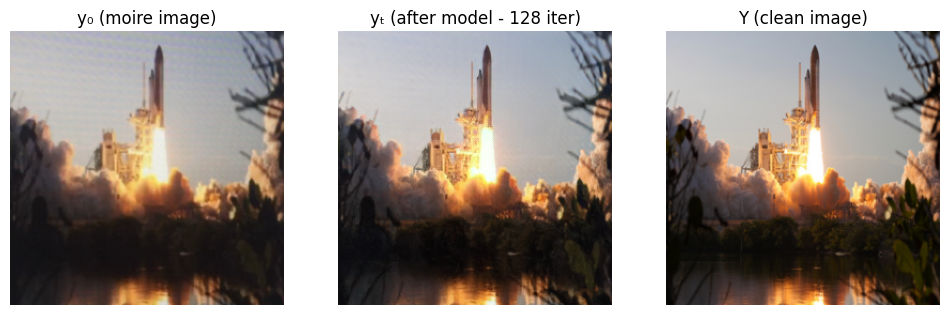

In [13]:
import torch

# --- Obtener batch ---
for i, (X, Y) in enumerate(val_loader):
    if i == 63:
        break

X, Y = X.cuda(), Y.cuda()

# --- Paso 1: dinámica tuya para obtener y0 ---
y0 = Y + (X - Y)

y0[y0 < 1e-8] = 1e-8

# --- Paso 2: aplicar 20 pasos del modelo ---
yt = y0.clone()
for i in range(300):
    with torch.no_grad():
        yt_actual = yt.clone()
        
        _, at, _ = model(yt)
        yt = yt + at*yt 
        
        # Modelo 114 con 0.05
        if torch.norm(yt - yt_actual).item() < 0.05:
            print(i)
            break

# =======================================================
# Visualización: y0 y yt en una sola fila
# =======================================================

# convierto tensores a formato (H,W,C) normalizado
def to_img(t, index):
    img = t[index].detach().cpu().clamp(0,1)
    if img.shape[0] == 3:   # C,H,W
        img = img.permute(1,2,0)
    return img.numpy()

index = 0

img_y0 = to_img(y0, index)
img_yt = to_img(yt, index)
img_Y = to_img(Y, index)

plt.figure(figsize=(12,5))

plt.subplot(1,3,1)
plt.imshow(img_y0)
plt.title("y₀ (moire image)")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(img_yt)
plt.title(f"yₜ (after model - {i} iter)")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(img_Y)
plt.title("Y (clean image)")
plt.axis("off")

plt.show()

In [ ]:
# El anterior es un ejemplo de que puede llegar a quitar texturas

In [14]:
import torch
import torch.nn.functional as F

from torchmetrics.image import PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure
import lpips


@torch.no_grad()
def evaluate_model(model, val_loader, device="cuda"):
    """
    Evalúa una red neuronal usando PSNR, SSIM y LPIPS.
    
    val_loader debe devolver pares (X, Y) en rango [0,1],
    donde X = entrada dañada, Y = ground truth.
    """

    model.eval()
    model.to(device)

    # Métricas
    psnr_metric = PeakSignalNoiseRatio(data_range=1.0).to(device)
    ssim_metric = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)
    lpips_metric = lpips.LPIPS(net='alex').to(device)   # alex es el más rápido

    psnr_total = []
    ssim_total = []
    lpips_total = []
    iter_counts = []
    count = 0

    for it, (X, Y) in enumerate(val_loader):
        print(it + 1, end="\r")
        
        X = X.to(device)
        Y = Y.to(device)

        # ---- FORWARD ----
        yt = X.clone()

        yt[yt < 1e-8] = 1e-8

        for i in range(300):
            with torch.no_grad():
                yt_actual = yt.clone()
                
                yt, _, _ = model(yt)

                if torch.norm(yt - yt_actual).item() < 0.05:
                    break
        
        # Updating the number of iterarions
        iter_counts.append(i)

        # ---- PSNR ----
        psnr_total.append(psnr_metric(yt, Y).item())

        # ---- SSIM ----
        ssim_total.append(ssim_metric(yt, Y).item())

        # ---- LPIPS ----
        # LPIPS espera [-1,1]
        pred_lp = yt * 2 - 1
        Y_lp = Y * 2 - 1
        lpips_total.append(lpips_metric(pred_lp, Y_lp).mean().item())

        count += 1

    # Promedios
    results = {
        "PSNR": psnr_total, # / count,
        "SSIM": ssim_total, # / count,
        "LPIPS": lpips_total, # / count,
        "Iter_Count": iter_counts
    }

    return results

# Test Set root
test_root = r"C:\Users\Usuario\Datasets\TIP-2018\testData\testData"
# Loadding Test Set 
test_loader = TIP2018_load_data(test_root, batch_size=1, rotation=False, shuffle=False) #, max_images=2)

# Performing evaluation for each image
eval_results = evaluate_model(model, test_loader)

Pares utilizables: 11038
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


C:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: C:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\lpips\weights\v0.1\alex.pth


In [15]:
print("PSNR; mean:", np.mean(eval_results["PSNR"]), "; std. dev.", np.std(eval_results["PSNR"]))
print()
print("SSIM; mean:", np.mean(eval_results["SSIM"]), "; std. dev.", np.std(eval_results["SSIM"]))
print()
print("LPIPS; mean:", np.mean(eval_results["LPIPS"]), "; std. dev.", np.std(eval_results["LPIPS"]))

PSNR; mean: 24.57151175288321 ; std. dev. 2.389737473392296

SSIM; mean: 0.795565910174333 ; std. dev. 0.07423395770455998

LPIPS; mean: 0.11027151276192942 ; std. dev. 0.04911862460697401


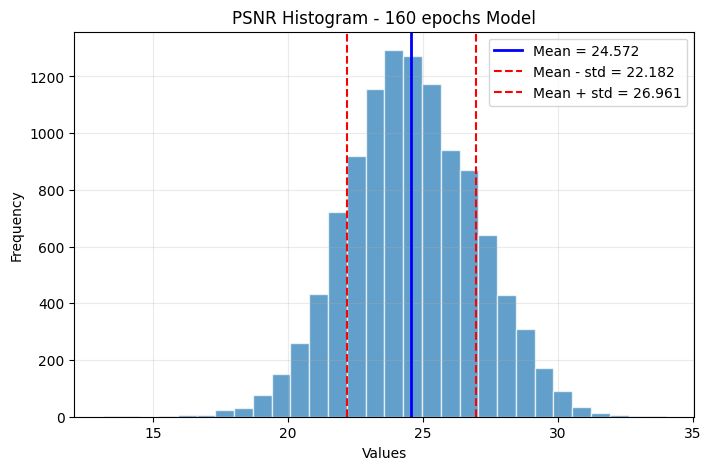

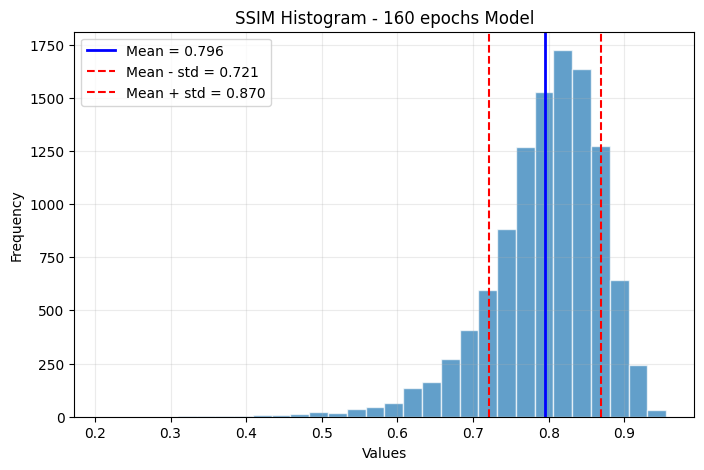

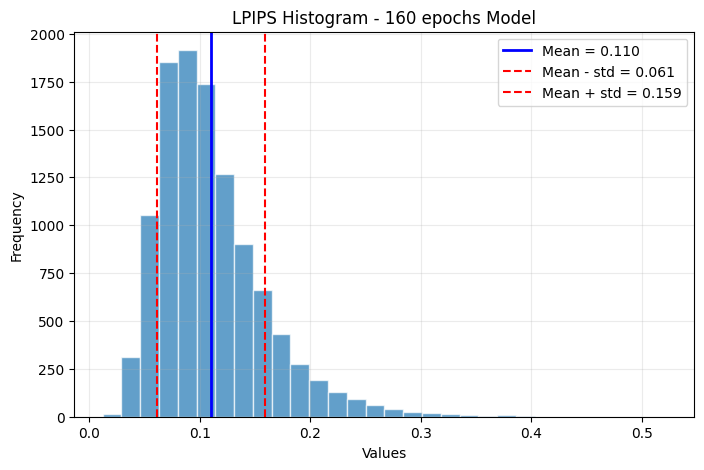

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def plot_hist_with_stats(values, bins=30, title="Histogram", color='C0'):
    """
    values: lista, numpy array o tensor de PyTorch
    bins: número de bins o vector de bordes
    title: título del gráfico
    """

    # Convertir a numpy si es tensor
    if not isinstance(values, np.ndarray):
        values = np.array(values)

    mean = values.mean()
    std = values.std()

    plt.figure(figsize=(8, 5))
    
    # Histograma
    plt.hist(values, bins=bins, ec='white', color=color, alpha=0.7)

    # Líneas verticales: media y media ± std
    plt.axvline(mean, color='blue', linestyle='-', linewidth=2, label=f"Mean = {mean:.3f}")
    plt.axvline(mean - std, color='red', linestyle='--', linewidth=1.5, label=f"Mean - std = {mean - std:.3f}")
    plt.axvline(mean + std, color='red', linestyle='--', linewidth=1.5, label=f"Mean + std = {mean + std:.3f}")

    plt.title(title)
    plt.xlabel("Values")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(alpha=0.25)
    plt.show()

plot_hist_with_stats(eval_results["PSNR"], title="PSNR Histogram - 160 epochs Model")

plot_hist_with_stats(eval_results["SSIM"], title="SSIM Histogram - 160 epochs Model")

plot_hist_with_stats(eval_results["LPIPS"], title="LPIPS Histogram - 160 epochs Model")

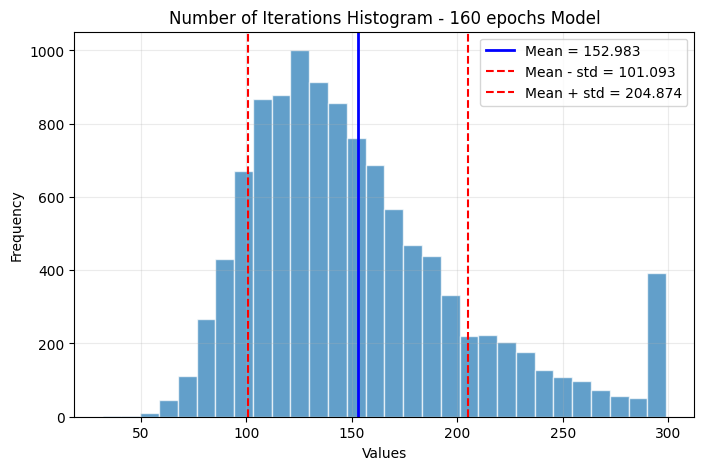

In [7]:
plot_hist_with_stats(eval_results['Iter_Count'], title="Number of Iterations Histogram - 160 epochs Model")

In [8]:
# Percentage of images that need more than 300 iterations to converge
np.sum([ i >= 290 for i in eval_results['Iter_Count']])/len(eval_results['Iter_Count'])

0.035785468381953255

In [23]:
# To save the dictionary
import pickle

def save_dict_pickle(data, filepath):
    with open(filepath, "wb") as f:
        pickle.dump(data, f, protocol=pickle.HIGHEST_PROTOCOL)

save_dict_pickle(eval_results, "results_test_model_160_epochs.pkl")

In [3]:
import pickle
import numpy as np

# To load the dictionary
def load_dict_pickle(filepath):
    with open(filepath, "rb") as f:
        return pickle.load(f)
        
# Upload the evaluation results
eval_results = load_dict_pickle("results_test_model_160_epochs.pkl")

# Training Package Modifications

In [5]:
import os
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import vgg16
from visualizer import *

def f(x):
  return 0.08*(2 / (1 + torch.exp(-x)) - 1)


def demoireing_forward(yT, y0, model, percent_training=0):
    # yT := Fully Moire Image
    # y0 := Clean image

    # To convert every zero value to 1e-8
    yT[yT == 0] = 1e-08
    
    # DETERMINING THE TRAINING STAGE (1,2,3)
    # If percent_training <= 0.2, first stage
    if percent_training <= 0.2:
        Training_Stage = 0
    # If percent_training <= 0.6, second stage
    elif percent_training <= 0.6:
        Training_Stage = 1
    # If percent_training <= 1, third stage
    else:
        Training_Stage = 2
    
    # To set the initial state (for fully moire)
    # This dependes on the training stage
    Prob_Init_Sate = [0.8, 0.6, 0.4]
    
    # Generation Strategies from Initial State: yT -> yk
    # 1 : Only using the Formula
    # 2 : Only using the Neural Net
    # 3 : A combination of Formula and the Neural Net
    
    # PERCENTAGE OF INTERMEDIATE GENERATORS AT EACH STAGE
    # Each interior list contains:
    #     index 0: Probability of generation using only the formula
    #     index 1: Probability of generation using the neural network
    #     we dont set, but the rest to reach 1 is the probability of using a mix of
    #     formula and the neural network
    percent_generators = [[0.6, 0.2], [0.3, 0.4], [0.1, 0.6]]
    
    # As a third option we can use a mix of formula and neural network
    # This is the probability of use the formula at each step of mixed strategy
    mixed_percent_generator = [0.5, 0.4, 0.3]
    
    # -------------------------------------------------------------------
    
    # To select the strategy of forward
    random = torch.rand(1).item()
    
    # The model must see 5% of clean images
    if random <= 0.05:
        return y0
    # The model must see 5% of fully moire images
    elif random <= 0.10:
        return yT
    
    # The model must see 5% of percentage of moire images
    elif random <= 0.15:
        # Percentage in (0.0001, 0.9999)
        percent = torch.rand(1).item() #0.9998*torch.rand(1).item() + 0.0001
        return y0 + percent*(yT - y0)
    
    # Intermediate states, will be 90% of values
    else:
        # For setting the initial state
        r1 = torch.rand(1).item()
        
        # INITIAL STATE -------------------------------------------------
        # To setting Fully Moire as Initial State
        if r1 <= Prob_Init_Sate[Training_Stage]:
            yt = yT.clone()
        else:
            # Percentage in (0.0001, 0.9999)
            percent = torch.rand(1).item() #0.9998*torch.rand(1).item() + 0.0001
            yt = y0 + percent*(yT - y0)
        
        # --------------------------------------------------------------
        
        
        # FOR LOOP GENERATION -------------------------------------------
        
        # Random generation of amount of steps
        n_steps = torch.randint(1, 10, (1, )).item()
        
        # Random Strategy Selector (depending of the Training Stage)
        selector = torch.rand(1).item()
        # If the selector <= the percentage generator for strategy 1 at Training Stage
        if selector <= percent_generators[Training_Stage][0]:
            strategy = 1
        # If the selector <= the percentage generator for strategy 2 at Training Stage
        elif selector <= percent_generators[Training_Stage][1]:
            strategy = 2
        # If the selector <= the percentage generator for strategy 3 at Training Stage
        else:
            strategy = 3
        
        
        # At the beginning of the loop yt is the Initial State
        
        for i in range(n_steps):
            if strategy == 1:
                yt = yt + f((y0 - yt) / (yt + 1e-08)) * yt
            
            elif strategy == 2:
                with torch.no_grad():
                    yt, _, _ = model(yt)
            
            else:
                # Mixed Strategy
                if torch.rand(1).item() < mixed_percent_generator[Training_Stage]:
                    yt = yt + f((y0 - yt) / (yt + 1e-08)) * yt
                else:
                    with torch.no_grad():
                        yt, _, _ = model(yt)
            
            # Stop Condition 
            close_ratio = (torch.isclose(yt, y0, rtol=0, atol=1e-10).sum()
                          / yt.numel())
            if close_ratio > 0.95:
                break
    return yt


def set_all_seed(seed: int = 42, deterministic: bool = True):
    """
    Set random seed for reproducibility across random, numpy, and torch.

    Args:
        seed (int): Random seed.
        deterministic (bool): If True, sets cudnn to deterministic mode
                              (slower but reproducible).
    """
    # Python
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    #os.environ["CUBLAS_WORKSPACE_CONFIG"] =  str(seed)

    # Numpy
    np.random.seed(seed)

    # Torch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # para multi-GPU

    # Deterministic flags
    if deterministic:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    else:
        torch.backends.cudnn.deterministic = False
        torch.backends.cudnn.benchmark = True

def update_metrics(epoch_losses, losses, metric_type, epoch, step=1, iteration=None, n_batches=None):
    """
    Actualiza las métricas para training o validation.
    - epoch_losses: acumulador de pérdidas (dict).
    - metric_type: "training" o "validation".
    - epoch: número de época (entero).
    - step: fracción dentro de la época (ej. 0.25).
    - iteration: batch actual (si es None, usa n_batches).
    - n_batches: total de batches en la época.
    """
    denom = iteration if iteration is not None else n_batches
    avg_losses = {m: epoch_losses[m] / denom for m in epoch_losses}

    losses[metric_type]["x"].append(epoch + step)
    for m, val in avg_losses.items():
        losses[metric_type]["y"][m].append(val)

def perform_validation(model, val_loader, criterion, losses, device):
    val_epoch_losses = {m: 0.0 for m in criterion.metrics_names}
    n_val_batches = len(val_loader)
    with torch.no_grad():
        for v_moire, v_gt in val_loader:
            v_moire, v_gt = v_moire.to(device), v_gt.to(device)

            # Update values
            v_moire = demoireing_forward(v_moire, v_gt, model)
            
            v_outputs = model(v_moire)
            v_total_loss, v_dict_losses = criterion(v_outputs, v_gt)
            for m in v_dict_losses:
                val_epoch_losses[m] += v_dict_losses[m]

    return val_epoch_losses


def save_model(model, optimizer, losses, epoch, scheduler=None, checkpoint_dir="checkpoints"):
    """
    Saves the model, optimizer, losses, epoch, RNG states, and optionally the scheduler.

    Args:
        model (torch.nn.Module): The trained model.
        optimizer (torch.optim.Optimizer): The optimizer.
        losses (list or dict): Loss history.
        epoch (int): Current epoch (saved as epoch + 1).
        scheduler (torch.optim.lr_scheduler._LRScheduler, optional): Learning rate scheduler.
        checkpoint_dir (str): Directory to save the checkpoint.
    """
    os.makedirs(checkpoint_dir, exist_ok=True)
    checkpoint_path = os.path.join(checkpoint_dir, f"model_epoch{epoch+1:03d}.pth")

    # Build checkpoint dictionary
    checkpoint = {
        "epoch": epoch + 1,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "losses": losses,

        # Random number generator states
        "numpy_rng_state": np.random.get_state(),
        "python_rng_state": random.getstate(),
        "torch_rng_state": torch.get_rng_state(),          # CPU
        "torch_cuda_rng_state": torch.cuda.get_rng_state() if torch.cuda.is_available() else None,
    }

    # Include scheduler state only if provided
    if scheduler is not None:
        checkpoint["scheduler_state_dict"] = scheduler.state_dict()

    torch.save(checkpoint, checkpoint_path)
    print(f"✅ Checkpoint saved: {checkpoint_path}")
    return checkpoint_path


def load_model_from_checkpoint(model, optimizer, checkpoint_path, scheduler=None, device=None):
    """
    Loads model, optimizer, losses, epoch, RNG states, and optionally the scheduler.

    Args:
        model (torch.nn.Module): Model (must have same architecture).
        optimizer (torch.optim.Optimizer): Optimizer.
        checkpoint_path (str): Path to the .pth file.
        scheduler (torch.optim.lr_scheduler._LRScheduler, optional): Scheduler (must be passed if it was saved).
        device (torch.device): Device to map the model to ('cpu' or 'cuda').

    Returns:
        model, optimizer, losses, epoch [, scheduler] if provided
    """
    if not os.path.exists(checkpoint_path):
        raise FileNotFoundError(f"Checkpoint not found: {checkpoint_path}")

    # Determine device for loading
    map_location = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load checkpoint
    try:
        checkpoint = torch.load(checkpoint_path, weights_only=False)
    except Exception as e:
        raise RuntimeError(f"Error loading checkpoint: {e}")

    # Load model and optimizer states
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

    epoch = checkpoint["epoch"]
    losses = checkpoint["losses"]

    # Restore random states
    np.random.set_state(checkpoint["numpy_rng_state"])
    random.setstate(checkpoint["python_rng_state"])
    torch.set_rng_state(checkpoint["torch_rng_state"])
    if torch.cuda.is_available() and checkpoint["torch_cuda_rng_state"] is not None:
        torch.cuda.set_rng_state(checkpoint["torch_cuda_rng_state"])

    # Load scheduler if provided and exists in checkpoint
    if scheduler is not None:
        if "scheduler_state_dict" in checkpoint:
            scheduler.load_state_dict(checkpoint["scheduler_state_dict"])
        else:
            print("⚠️ Warning: Scheduler was provided, but 'scheduler_state_dict' not found in checkpoint.")

    print(f"✅ Checkpoint loaded: {checkpoint_path}")
    print(f"   Last epoch: {epoch}")

    if scheduler is not None:
        return model, optimizer, losses, epoch, scheduler
    else:
        return model, optimizer, losses, epoch
    return model, optimizer, losses, epoch

def get_fixed_samples(val_loader, n_samples=4, device='cuda'):
    dataset = val_loader.dataset
    moires, gts = [], []
    for i in range(n_samples):
        moire, gt = dataset[i]  # acceso directo a las muestras
        moires.append(moire)
        gts.append(gt)
    moires = torch.stack(moires).to(device)
    gts = torch.stack(gts).to(device)
    return moires, gts

def visualizer_epoch(model, moire_fixed, gt_fixed, losses, epoch, iteration, save_dir=r"results/samples"):

    est_fixed = model(moire_fixed)
    if isinstance(est_fixed, tuple):
        est_fixed = est_fixed[0]#moire_fixed + est_fixed[1]*moire_fixed #est_fixed[0]

    at_ = f((gt_fixed - moire_fixed)/(moire_fixed + 1e-8))
    gt_fixed = moire_fixed + at_*moire_fixed

    images_tuple = (moire_fixed, est_fixed, gt_fixed)

    visualize_training(
        losses=losses,
        images_tuple=images_tuple,
        epoch=epoch,
        iteration=iteration,
        save_dir=save_dir,
        max_samples=9,
        view=True
    )

# Dentro de la función ________________________________________________________________________________________
def train_model(
    model,
    criterion,
    train_loader,
    val_loader,
    epochs,
    optimizer,
    train_device="cuda",
    checkpoint_path=None,
    scheduler=None,
    seed=None,
    view_every=5,         # Step to visualize advance of the training
    metrics_iteration=3,  # How many time calculate metrics in one epoch
    view_first_epoch=5,   # To se the first n iterations in the first epoch
    visual_by_channels=False,
    visual_channels_cmap='inferno'
):
    # Setting som parameter of the training
    device = torch.device(train_device if torch.cuda.is_available() else "cpu")

    # Sending model and criterion to device
    model = model.to(device)
    criterion = criterion.to(device)

    start_epoch = 0

    # Losses will have a unique share X axis
    losses = {
        phase: {"x": [], "y": {m: [] for m in criterion.metrics_names}}
        for phase in ["training", "validation"]
    }

    # If you want to load a
    if checkpoint_path != None:
        if scheduler is None:
            model, optimizer, losses, start_epoch = load_model_from_checkpoint(model, optimizer, checkpoint_path)
        else:
            model, optimizer, losses, start_epoch, scheduler = load_model_from_checkpoint(model, optimizer, checkpoint_path, scheduler)

    # If we train from sratch
    else:
        if not seed is None: # If seed was defined
            set_all_seed(seed)

    # We always use the same fixed batch for visualization
    # moire_fixed, gt_fixed = next(iter(val_loader))
    # moire_fixed, gt_fixed = moire_fixed.to(device), gt_fixed.to(device)
    moire_fixed, gt_fixed = get_fixed_samples(val_loader, n_samples=4, device=device) # To get always 4 images
    #moire_fixed_, gt_fixed_, _, _ = normalize(moire_fixed_, gt_fixed_)

    n_batches = len(train_loader)

    if epochs < start_epoch:
        raise ValueError("Number of epochs must be greater than or equal to start_epoch")

    for epoch in range(start_epoch, epochs):
        model.train()

        epoch_losses = {m: 0.0 for m in criterion.metrics_names}

        for iteration, (moire, gt) in enumerate(train_loader, 1):
            #moire, gt, _, _ = normalize(moire, gt)
            moire, gt = moire.to(device), gt.to(device)

            moire = demoireing_forward(moire, gt, model, percent_training=epoch/epochs)
            
            # Forward
            model.train()
            outputs = model(moire)
            total_loss, dict_losses = criterion(outputs, gt)

            # Printing metrics
            print(f"\rEpoch: {epoch+1}/{epochs} - Iter.: {iteration}/{n_batches} - Loss: {total_loss}", end='', flush=True)

            # Backward
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

            # Acumular para promedio (train epoch)
            for m in dict_losses:
                epoch_losses[m] += dict_losses[m]

            # Visualización con batch fijo
            if (iteration % view_every == 0) or (iteration == 1) or (epoch == 0 and iteration < view_first_epoch):
                was_training = model.training # To visualiza in eval
                model.eval()

                moire_fixed = demoireing_forward(moire_fixed, gt_fixed, model, percent_training=epoch/epochs)

                with torch.no_grad():
                    if visual_by_channels:
                        visualizer_epoch_by_channel(model, moire_fixed, gt_fixed, losses, epoch, iteration, cmap=visual_channels_cmap)
                    else:
                        visualizer_epoch(model, moire_fixed, gt_fixed, losses, epoch, iteration)

                if was_training:
                    model.train()

            # --- MÉTRICAS INTERMEDIAS ---
            if (metrics_iteration > 0) and (iteration % metrics_iteration == 0) and (iteration < n_batches - 1):
                frac = iteration / n_batches  # ej. 0.25, 0.5, 0.75

                # --- TRAINING AVG hasta aquí ---
                update_metrics(epoch_losses, losses, "training", epoch, step=frac, iteration=iteration)

                # --- VALIDATION PARCIAL ---
                model.eval()
                val_epoch_losses = perform_validation(model, val_loader, criterion, losses, device)
                update_metrics(val_epoch_losses, losses, "validation", epoch, step=frac, n_batches=len(val_loader))
                model.train()

        # --- TRAIN AVG EPOCH ---
        update_metrics(epoch_losses, losses, "training", epoch, n_batches=n_batches)

        # --- VALIDATION AVG EPOCH ---
        model.eval()
        val_epoch_losses = perform_validation(model, val_loader, criterion, losses, device)
        update_metrics(val_epoch_losses, losses, "validation", epoch, n_batches=len(val_loader))

        # Plotting graphs
        if epoch > 0:
            plot_metrics(losses, epochs, epoch + 1, save_dir=r"results\losses")

        print(f"\r Epoch {epoch+1} avg train losses: {losses['training']['y']['Total_Loss'][-1]}", flush=True)
        print(f"\r Epoch {epoch+1} avg val losses:   {losses['validation']['y']['Total_Loss'][-1]}", flush=True)

        # === Guardar checkpoint del modelo ===
        checkpoint_root = "checkpoints"
        if scheduler is not None:
            save_model(model, optimizer, losses, epoch, scheduler, checkpoint_dir=checkpoint_root)
        else:
            save_model(model, optimizer, losses, epoch, checkpoint_dir=checkpoint_root)


class VGGPerceptual(nn.Module):
    """
    Extract features from VGG16 conv3_3 (after ReLU).
    """
    def __init__(self, device="cuda"):
        super().__init__()
        vgg = vgg16(weights="IMAGENET1K_V1").features
        # conv3_3 is layer 16 (after ReLU in PyTorch's vgg16)
        self.slice = nn.Sequential(*list(vgg.children())[:17])
        for p in self.slice.parameters():
            p.requires_grad = False
        self.slice.eval()
        self.slice.to(device)

    def forward(self, x):
        return self.slice(x)


class MultiScaleLoss(nn.Module):
    """
    Multiscale L1 + Perceptual loss for MBCNN-like models.

    Args:
        device: device to run VGG perceptual model.
    """
    def __init__(self, device="cuda"):
        super().__init__()
        self.l1 = nn.L1Loss()
        self.vgg = VGGPerceptual(device=device)

        self.metrics_names = ["Total_Loss", "L1", "Lp"]

    def forward(self, outputs, target):
        """
        Args:
            outputs: tuple of 3 tensors (out1, out2, out3),
                     each of shape [N, C, H, W].
            target: ground truth tensor [N, C, H, W].
        Returns:
            L_total: scalar tensor
            loss_dict: dict with {"L1": float, "Lp": float}
        """
        out1, out2, out3 = outputs

        # Resize ground truth for each scale
        gt1 = target
        gt2 = F.interpolate(target, size=out2.shape[2:], mode="bilinear", align_corners=False)
        gt3 = F.interpolate(target, size=out3.shape[2:], mode="bilinear", align_corners=False)

        # Pixel-level L1 loss
        L1 = (self.l1(out1, gt1) +
              self.l1(out2, gt2) +
              self.l1(out3, gt3))

        # Perceptual loss (VGG conv3_3)
        f_out1, f_gt1 = self.vgg(out1), self.vgg(gt1)
        f_out2, f_gt2 = self.vgg(out2), self.vgg(gt2)
        f_out3, f_gt3 = self.vgg(out3), self.vgg(gt3)

        Lp = (self.l1(f_out1, f_gt1) +
              self.l1(f_out2, f_gt2) +
              self.l1(f_out3, f_gt3))

        # Total loss
        L_total = L1 + Lp
        loss_dict = {"Total_Loss": L_total.item(), "L1": L1.item(), "Lp": Lp.item()}

        return L_total, loss_dict
